# CMSC320 Final Project

# **Prediction of Fake vs. Real Job Postings**
### *Spring 2025 Data Science Project*

**Collaborators**: Claire Chen, Rachel Kim, Ilayda Dogan, Hellen Ou, Aidana Aibek, Joshua Au

**Contributions**:

A: Project idea

B: Dataset Curation and Preprocessing

C: Data Exploration and Summary Statistics

D: ML Algorithm Design/Development

E: ML Algorithm Training and Test Data Analysis

F: Visualization, Result Analysis, Conclusion

G: Final Tutorial Report Creation

H: Additional (not listed above)


## **Introduction**

In today's digital job market, online job boards and applications have become the primary way for job seekers to find employment opportunities. As the number of job postings on the Internet increase, so does the number of fake job postings. These fraudulent listings may be designed to scam applicants by stealing personal data, extracting feeds, or even recruit for illegal activities. Furthermore, a survey from Resume Builder states that 40% of hiring managers admitted to posting fake job listings in 2024, with 70% considering this practice acceptable. Their justifications ranged from creating illusions of company growth to manipulating employee morale and productivity metrics.

For job seekers, particularly college students like ourselves actively searching for internships and entry-level positions, this presents a serious challenge. Unlike traditional in-person applications where authenticity can be more easily verified, online postings often appear professional and convincing while hiding malicious intentions. These scams range from identity theft schemes to advanced fee frauds, putting vulnerable applicants at risk of financial loss, data breaches, and emotional distress.

The goal of our analysis is to be able to predict whether a job posting is fradulent based on specific features of the listing. These include the presence of a company logo, employment type, required experience, required education, and industry classification. In this process, we will also be able to determine which features are the most important in determining fradulency.

By identifying the most important factors that differentiate real jobs from fake ones, we can help job seekers, like us, avoid scams while providing insights for job platforms to improve fraud detection systems. This is important because falling victim and applying to fake job postings can have serious consequences, from identity theft and financial loss to wasted time and emotional distress. Therefore, it is crucial that applicants are able to distinguish between fake and real job postings. Finding features that best identify fake job postings will benefit all future job applicants who are looking to find real jobs.

Sources:
1. https://www.fox26houston.com/news/fake-jobs-becoming-growing-problem-real-job-seekers
2. https://www.wsj.com/lifestyle/careers/ghost-jobs-2c0dcd4e

In [1]:
# necessary imports
!pip install kaggle
!pip install opendatasets

import os
import torch
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import torch.nn as nn
import opendatasets as od
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from google.colab import drive
from scipy.stats import ttest_ind
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, silhouette_score
from sklearn.decomposition import PCA

## **Data Curation**

**Dataset Citations:**

Bansal, S. (2024, May). Real / Fake Job Posting Prediction, Version 1. Retrieved February 25 from https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction.

Sanisetty, S.S.S, & Namrithaa (2024, December). Fake Job Postings, Version 1. Retrieved February 25 from https://www.kaggle.com/datasets/srisaisuhassanisetty/fake-job-postings.

In this project, we will use two Kaggle datasets containing both real and fake job postings. The first dataset, Real / Fake Job Posting Prediction, contains the posting's title, geographical location, corporate department (e.g. sales), indicative salary range, a brief company description, description of the job ad, enlisted requirements for the job opening, enlisted offered benefits by the employer, a boolean value for telecommuting positions, whether the company logo is present and screening questions are present, employment type, required experience, required education, industry, function, and whether the posting is fradulent or not. This final feature is the target.

The second dataset, Fake Job Postings, contains a posting's title, description, requirements, company profile, location, salary range, employment type, industry, benefits, and whether the posting is fraudulent.

First, we will use the opendatasets Python library to download the datasets. It will prompt you to log in with your Kaggle credentials. You can find your username and kaggle key by clicking on your profile, navigating to settings, and clicking "Create New Token" under "API". Open the .json file and copy-paste the information. Make sure to allow access to your Google Drive.

In [2]:
od.download("https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction")
od.download("https://www.kaggle.com/datasets/srisaisuhassanisetty/fake-job-postings")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: technicaops
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/shivamb/real-or-fake-fake-jobposting-prediction
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: technicaops
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/srisaisuhassanisetty/fake-job-postings


Next, we will import the datasets from Google Drive. Make sure you have the datasets downloaded in the same folder as this colab, then mount the drive and create a dataframe from each dataset. We will print the shape, features, and data types of both datasets to explore further.

In [3]:
drive.mount("/content/drive")

df_1 = pd.read_csv("/content/real-or-fake-fake-jobposting-prediction/fake_job_postings.csv")
df_2 = pd.read_csv("/content/fake-job-postings/Fake Postings.csv")
print(df_1.shape)
print(df_2.shape)

Mounted at /content/drive
(17880, 18)
(10000, 10)


In [4]:
display(df_1.head())
print(df_1.columns)
print(df_1.shape)
print(df_1.dtypes)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')
(17880, 18)
job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object


Using the isna() and sum() functions, we can see that there are many missing values, especially department and salary range. We will drop these columns, as there are too many missing fields.

In [5]:
df_1.isna().sum()

,0
job_id,0
title,0
location,346
department,11547
salary_range,15012
company_profile,3308
description,1
requirements,2696
benefits,7212
telecommuting,0


In [6]:
#Columns with a majority NAs: department, salary_range
df_1.drop(columns=["department", "salary_range"], inplace=True)

For the rest of the missing values, since the existence of the values could differentiate between fake and real job postings (making the missing values MNAR), we will fill them with the string "No [field]".

In [7]:
  #currently I filled it in this way because I'm wondering if the data being missing could actually help in predicting that the posting is fraudulent
  #(e.g. missing descriptor -- more likely to be fake)
  #however we can change this and fill in NAs a different way!
  df_1["company_profile"].fillna("No Company Profile", inplace=True)
  df_1["description"].fillna("No Description", inplace=True)
  df_1["requirements"].fillna("No Requirements", inplace=True)
  df_1["benefits"].fillna("No Benefits", inplace=True)
  df_1["employment_type"].fillna("Not specified", inplace=True)
  df_1["required_experience"].fillna("Not specified", inplace=True)
  df_1["required_education"].fillna("Not specified", inplace=True)
  df_1["location"].fillna("Not specified", inplace=True)

<ipython-input-7-34d742bfc917>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_1["company_profile"].fillna("No Company Profile", inplace=True)
<ipython-input-7-34d742bfc917>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

## **Exploratory Data Analysis**

By looking at the unique locations in the first dataset, we can see that it is in the format of 'Country abbreviation, state abbreviation, city name'. We need to standardize these locations by accounting for a few things:



1.   Countries other than the United States may not have states, resulting in blank fields
2. Fort Worth is in Texas, not Florida! However, since we don't want to alter the original data (it could also be a sign of a fraudulent job posting), we'll leave that as is.
3. Sometimes the city is not given, and we can't encode it due to a lack of data. We can't just guess which city.



In [8]:
# Display all unique locations in the dataset
display(df_1["location"].unique().tolist()[0:10])

# For each location, standardize the format
# Fill in any missing values with N/A
processed = []
for entry in df_1["location"]:
    parts = str(entry).split(',')

    parts = [p.strip() for p in parts]
    if len(parts) < 3:
        parts += ['N/A'] * (3 - len(parts))
    elif len(parts) > 3:
        parts = parts[:2] + [', '.join(parts[2:])]
    processed.append(parts)

temp_locations_df = pd.DataFrame(processed, columns=['country', 'state', 'city'])
temp_locations_df.replace('', 'N/A', inplace=True)
df_1["location"] = temp_locations_df['country'] + ', ' + temp_locations_df['state'] + ', ' + temp_locations_df['city']
display(df_1["location"])
display(df_1.head())

['US, NY, New York',
 'NZ, , Auckland',
 'US, IA, Wever',
 'US, DC, Washington',
 'US, FL, Fort Worth',
 'US, MD, ',
 'DE, BE, Berlin',
 'US, CA, San Francisco',
 'US, FL, Pensacola',
 'US, AZ, Phoenix']

,location
0,"US, NY, New York"
1,"NZ, N/A, Auckland"
2,"US, IA, Wever"
3,"US, DC, Washington"
4,"US, FL, Fort Worth"
...,...
17875,"CA, ON, Toronto"
17876,"US, PA, Philadelphia"
17877,"US, TX, Houston"
17878,"NG, LA, Lagos"


,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,No Benefits,0,1,0,Other,Internship,Not specified,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, N/A, Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Not specified,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,No Benefits,0,1,0,Not specified,Not specified,Not specified,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Let's look at the distribution of fraudulent and non-fraudulent job postings. The counts show that there are much more fraudulent postings, 17,014, compared to the 866 fradulent postings. Therefore, we will have to account for this class imbalance later.

In [9]:
df_1["fraudulent"].value_counts()

,count
fraudulent,
0,17014
1,866


**Conclusion 1**: The features: "Fraudulent" and "Has Company Logo" are correlated because for all the non-fraudulent companies, the percentage of missing logo to having logos is a lot lower than that of fraudulent companies.

Text(0.5, 0, 'Is Fraudulent')

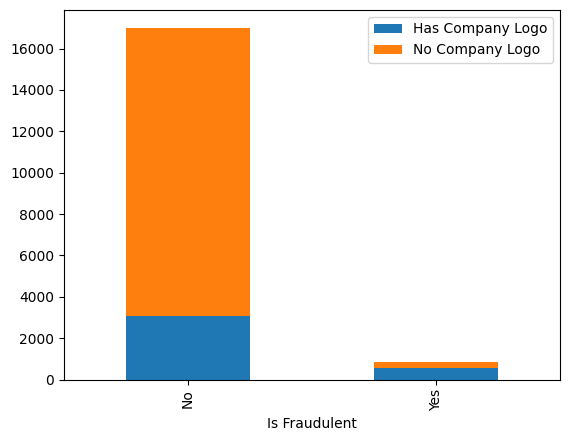

In [10]:
groups = df_1.groupby(["fraudulent", "has_company_logo"])["job_id"].count().rename({1: "Yes", 0: "No"})
ax = groups.unstack().plot(kind='bar', stacked=True)
ax.legend(["Has Company Logo", "No Company Logo"]);
ax.set_xlabel("Is Fraudulent")

**Hypothesis Test: Chi-Squared Test**
We will perform a chi-squared test to determine if fraudulence and required education are independent. Absence of required education will be counted as a type of required education, as no required education could be a trait of fraudulent job postings.

**Null Hypothesis H0:** The required education for the job posting does not have an effect on its fraudulence

**Null Hypothesis HA:** The required education for the job posting does have an effect on its fraudulence

In [11]:
# Removed "Not specified" because there is already a value "Unspecified" for required_education
df_ch = df_1[df_1['required_education'] != 'Not specified']
crosstab = pd.crosstab(df_ch['required_education'], df_ch['fraudulent'], rownames=['Required Education'], colnames=['Fraudulent'])
crosstab

Fraudulent,0,1
Required Education,,
Associate Degree,268,6
Bachelor's Degree,5045,100
Certification,151,19
Doctorate,25,1
High School or equivalent,1910,170
Master's Degree,385,31
Professional,70,4
Some College Coursework Completed,99,3
Some High School Coursework,7,20


Plotting the required education distribution for fradulent jobs vs. non-fraudulent jobs shows that fraudulent job postings are more likely to require a high school level education over other levels, while many non-fradulent postings require at least a college degree. This is taking into account the class imbalance betweeen the fraudulent and non-fraudulent postings; a bigger proportion of the fraudulent postings require a high school level education compared to the proportion of the non-fraudulent postings.

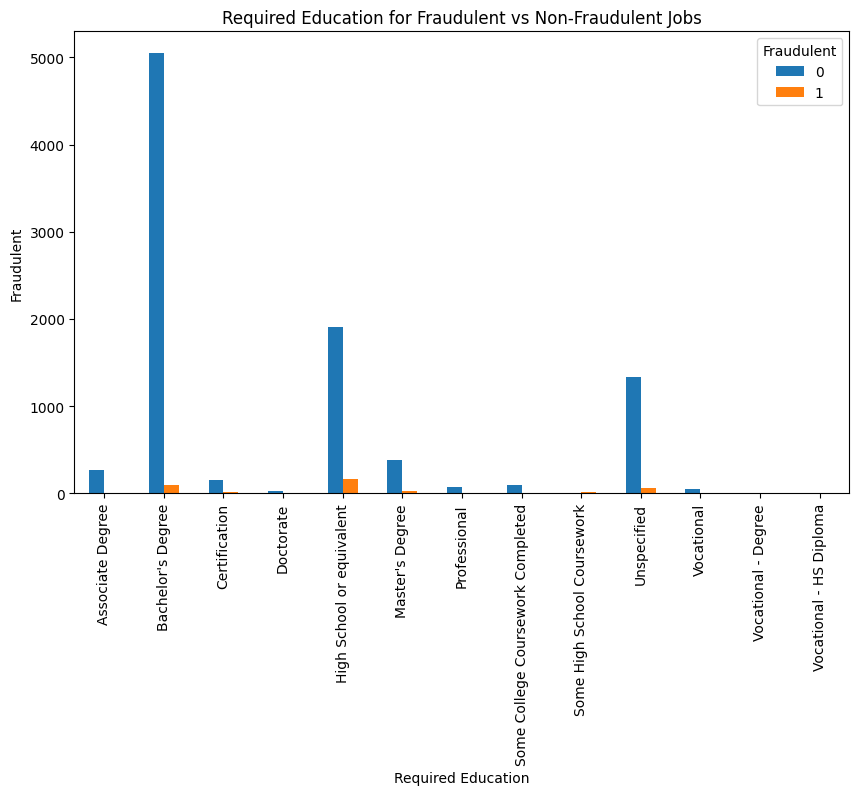

In [12]:
crosstab.plot(kind='bar', figsize=(10,6))

plt.xlabel("Required Education")
plt.ylabel("Fraudulent")
plt.title("Required Education for Fraudulent vs Non-Fraudulent Jobs")

plt.show()

In [13]:
res = sp.stats.chi2_contingency(crosstab)
display(res.pvalue)

np.float64(7.684947749658579e-101)

**Conclusion 2:** To determine if fraudulence is independent from the required education of the job posting, we created a crosstab between these two features and performed a chi-square test. The resulting p-value was 7.009207304287559e-91, which is extremely small. If we choose α=0.05, 𝑝−𝑣𝑎𝑙𝑢𝑒≤α, so we reject the null hypothesis. The final conclusion is that the required education does have an effect on fraudulence, with the graph showing that fraudulent job postings tend to require high school or equivalent education more than non-fraudulent job postings. Surprisingly, a lot more non-fraudulent postings had unspecified required education than fraudulent postings.

**T-Test:**
We will perform a t-test to determine whether there is a statistically significant association between telecommuting availability and fraudulent job postings.

**Null Hypothesis $H_0$:** Telecommuting status has no effect on fraudulence (the variables are independent).

**Null Hypothesis $H_A$:** Telecommuting status affects fraudulence (the variables are associated).

t-statistic: 3.61, p-value: 0.0003


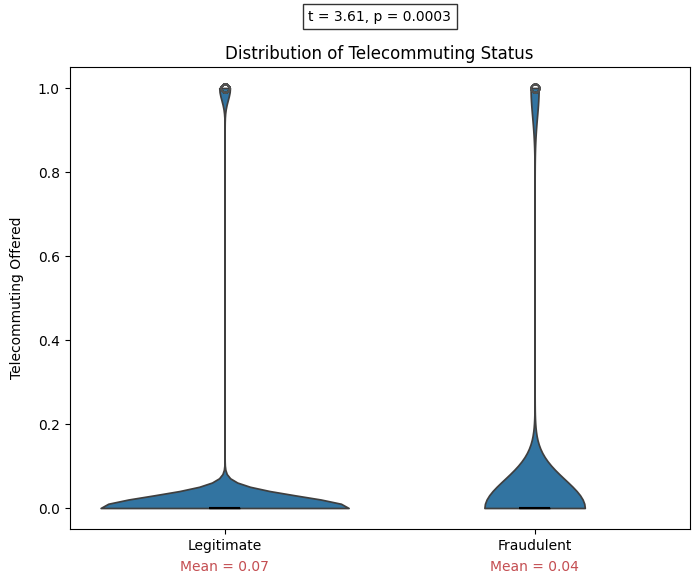

Legitimate: Mean=0.04, SD=0.199
Fraudulent: Mean=0.07, SD=0.262
Fraudulent skew: 3.263115513286459
Legitimate skew: 4.609646174031776


In [14]:
# Split the fradulent column into two series, fraudulent and non-fraudlent,
# selecting the telecommuting feature for both
fraudulent = df_1[df_1['fraudulent'] == 1]['telecommuting']
non_fraudulent = df_1[df_1['fraudulent'] == 0]['telecommuting']

# Conduct the t-test using the ttest_ind function from scipy
t_stat, p_value = ttest_ind(fraudulent, non_fraudulent, equal_var=False)

print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

# Plot results using a violin plot
plt.figure(figsize=(8, 6))

sns.violinplot(
    x='fraudulent',
    y='telecommuting',
    data=df_1,
    cut=0,
    inner=None
)

sns.boxplot(
    x='fraudulent',
    y='telecommuting',
    data=df_1,
    width=0.1,
    boxprops={'facecolor':'none', 'edgecolor':'black'},
    whiskerprops={'color':'black', 'linewidth': 1.5},
    showcaps=False,
    medianprops={'color':'black', 'linewidth': 1.5}
)

plt.text(0, -0.15, f'Mean = {fraudulent.mean():.2f}', ha='center', color='#C44E52')
plt.text(1, -0.15, f'Mean = {non_fraudulent.mean():.2f}', ha='center', color='#C44E52')

plt.title('Distribution of Telecommuting Status')
plt.xticks([0, 1], ['Legitimate', 'Fraudulent'])
plt.xlabel('')
plt.ylabel('Telecommuting Offered', labelpad=10)

plt.text(0.5, 1.1, f't = {t_stat:.2f}, p = {p_value:.4f}',
         ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

print(f"Legitimate: Mean={non_fraudulent.mean():.2f}, SD={non_fraudulent.std():.3f}")
print(f"Fraudulent: Mean={fraudulent.mean():.2f}, SD={fraudulent.std():.3f}")

print("Fraudulent skew:", fraudulent.skew())
print("Legitimate skew:", non_fraudulent.skew())

**Conclusion 3:** To determine whether telecommuting status is independent of job posting fraudulence, we performed a t-test. The resulting t-statistic was $t = 3.61$ and p-value was $0.0003$, which is less than the significance level of $α = 0.05$. Since $p < α$, we can reject the null hypothesis. This data suggests that the telecommuting availability of a job posting is associated with the job posting being fradulent.

As for the violin plots generated, the wider violin for the legitimate job postings indicates that there is more variability in telecommuting offers. This means that legitimate companies vary a lot in their offerings for telecommunication. Some may offer it (values at 1), some don't (values at 0). The narrower fraudulent violin suggests that scammers are more consistent with their selection of telecommunication in fake job postings. They don't follow the variety of options as seen in real job postings. These interpretations align with the real world, as legitimate employers have varying telecommunication policies for each role and industry in the job market, and may have hybrid or partial options as well. Scammers, on the other hand, tend to use fast, binary approaches when creating fake jobs and often overlook the complexity that goes into job descriptions and details.

After analyzing the standard deviation and skewness of both plots, it appears that the fraudulent job postings (skew = 3.26) have most values cluster near 0 with rare telecommuting offers. The legitimate job postings (skew = 4.61) are even more extreme and clustered near 0. The high standard deviations of 0.199 and 0.262 come from the extreme values of 0 and 1. Both distributions are extremely right-skewed, with the fraudulent distribution being less skewed.

For the primary analysis, we use four models: Logistic Regression, KNN, Decision Tree, and Random Forest. After selecting features and transforming the data, we split it into train and test sets, then perform k-fold Cross-Validation, and finally fit and evaluate the model.

## **Primary Analysis**

For the primary analysis, we first select eight features and transform categorical data to numerical using LabelEncoder(). Then, we create a dataset Y for the target variable and train_test_split. We will use four models, Logistic Regression, KNN, Decision Tree, and Random Forest. After performing k-fold Cross-Validation with 5 folds, we fit and evaluate the models.

Based on the resulting classification report, the Random Forest model performed the best. It has the highest accuracy and among the lowerst standard deviation overall, while also having high precision, recall, and f1-scores for the target variable.

Start ML Training

In [15]:
X = df_1[['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']].copy()
label_encoder = LabelEncoder()
X['employment_type_enc'] = label_encoder.fit_transform(X['employment_type'])
X['required_experience_enc'] = label_encoder.fit_transform(X['required_experience'])
X['required_education_enc'] = label_encoder.fit_transform(X['required_education'])
X.drop(columns=['employment_type', 'required_experience', 'required_education'], inplace=True)

# Use one hot encoding for industry and function
X['industry'].fillna('Not specified', inplace=True)
X['function'].fillna('Not specified', inplace=True)
X = pd.get_dummies(X, columns=['industry', 'function'], drop_first=True, dtype=int)

Y = df_1["fraudulent"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
         }

k_folds = 5
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Perform k-fold Cross-Validation for each model
for model_name, model in models.items():
    np.random.seed(42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{model_name}: Mean Accuracy = {scores.mean():.4f}, Std Dev = {scores.std():.4f}")

# Train each model using the training data
for model_name, model in models.items():
    np.random.seed(42)
    model.fit(X_train, y_train)

# Evaluate the performance of each model
for model_name, model in models.items():
    np.random.seed(42)

    y_pred =  model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy of {model_name}: {accuracy:.3f}")
    print(classification_report(y_test, y_pred))

<ipython-input-15-52a4bf47d669>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['industry'].fillna('Not specified', inplace=True)
<ipython-input-15-52a4bf47d669>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

Logistic Regression: Mean Accuracy = 0.9562, Std Dev = 0.0012
KNN: Mean Accuracy = 0.9597, Std Dev = 0.0055
Decision Tree: Mean Accuracy = 0.9649, Std Dev = 0.0026
Random Forest: Mean Accuracy = 0.9697, Std Dev = 0.0029
Accuracy of Logistic Regression: 0.952
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      3395
           1       0.69      0.10      0.17       181

    accuracy                           0.95      3576
   macro avg       0.82      0.55      0.57      3576
weighted avg       0.94      0.95      0.93      3576

Accuracy of KNN: 0.966
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3395
           1       0.74      0.52      0.61       181

    accuracy                           0.97      3576
   macro avg       0.86      0.76      0.80      3576
weighted avg       0.96      0.97      0.96      3576

Accuracy of Decision Tree: 0.964
              precision    reca

Next, we will create a matrix in preparation for training and testing a Neural Network through Pytorch. Again, we select our eight features, encode them using LabelEncoder, and use one hot encoding for industry and function, which have a lot of empty values.

In [16]:
# Want (n,d) matrix where n is the number of examples and d is the number of features
df_features = df_1[['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']]

# Use label encoding for employment_type, required_experience, required_education
label_encoder = LabelEncoder()
df_features['employment_type_enc'] = label_encoder.fit_transform(df_features['employment_type'])
df_features['required_experience_enc'] = label_encoder.fit_transform(df_features['required_experience'])
df_features['required_education_enc'] = label_encoder.fit_transform(df_features['required_education'])
df_features.drop(columns=['employment_type', 'required_experience', 'required_education'], inplace=True)

# Use one hot encoding for industry and function
df_features['industry'].fillna('Not specified', inplace=True)
df_features['function'].fillna('Not specified', inplace=True)
df_features = pd.get_dummies(df_features, columns=['industry', 'function'], drop_first=True, dtype=int)

features = df_features.to_numpy()
labels = df_1['fraudulent'].to_numpy().T

print(features.shape)
print(labels.shape)


(17880, 174)
(17880,)


<ipython-input-16-f36f40e5cf12>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['employment_type_enc'] = label_encoder.fit_transform(df_features['employment_type'])
<ipython-input-16-f36f40e5cf12>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features['required_experience_enc'] = label_encoder.fit_transform(df_features['required_experience'])
<ipython-input-16-f36f40e5cf12>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

It's time to prepare the data. We will create splits, normalize the data using StandardScaler, convert to PyTorch tensors, create data loaders, then create train/test loaders and define the batch size, number of training and testing data, and feature dimension. Before we train the model, we will apply PCA to reduce dimensionality and minimize overfitting.

In [17]:
# Create the splits
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32

### DO NOT MODIFY BELOW
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

batch_size = train_loader.batch_size
num_train_data = len(train_loader) * batch_size
num_test_data = len(test_loader) * batch_size
feat_dim = train_loader.dataset[0][0].shape[0]

print("Batch Size:", batch_size)
print("Number of Train Data:", num_train_data)
print("Number of Test Data:", num_test_data)
print("Feature Dimension Before PCA:", feat_dim)

# Extract the feature importances

importances = models['Random Forest'].feature_importances_

# Creating a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': df_features.columns,
    'Importance': importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Displaying feature importances
most_important = feature_importance_df.sort_values(by=['Importance'], ascending=False).head(4)

# Select most relevant features for clustering (exclude 'rating')
important_features = most_important['Feature'].to_numpy()
X_subset = df_features[important_features]
print(X_subset)


# Standardize the data
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

# Apply PCA and return the transformed data

def apply_pca(X_scaled, n_components=2):
    pca = PCA(n_components=n_components, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    return pca, X_pca

pca, X_pca = apply_pca(X_scaled)
print("Feature Dimension After PCA:", X_pca.shape)

Batch Size: 32
Number of Train Data: 14304
Number of Test Data: 3584
Feature Dimension Before PCA: 174
       has_company_logo  required_experience_enc  required_education_enc  \
0                     1                        4                       6   
1                     1                        6                       6   
2                     1                        7                       6   
3                     1                        5                       1   
4                     1                        5                       1   
...                 ...                      ...                     ...   
17875                 1                        5                       6   
17876                 1                        5                       1   
17877                 0                        7                       6   
17878                 0                        6                       7   
17879                 1                        5             

Now, let's define the neural network model, creating fully-connected layers and applying RELU in the forward function.

In [18]:
# Define the model
class Model(nn.Module):
  def __init__(self, feat_dim):
    super(Model, self).__init__()

    self.fc1 = nn.Linear(feat_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 1)

  def forward(self, X_pca):
    X = F.relu(self.fc1(X_pca))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return X.squeeze()

model = Model(feat_dim=feat_dim)

After that, we'll set the criterion to be BCEWithLogitsLoss, which combines a Sigmoid layer and the BCELoss in one single class. We will use the Adam optimizer. Running through 100 epochs, we'll train our model.

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 100
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        outputs = model(data)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

print('Finished Training')

Epoch 1/100, Loss: 0.1662
Epoch 2/100, Loss: 0.1194
Epoch 3/100, Loss: 0.1065
Epoch 4/100, Loss: 0.0986
Epoch 5/100, Loss: 0.0929
Epoch 6/100, Loss: 0.0876
Epoch 7/100, Loss: 0.0836
Epoch 8/100, Loss: 0.0816
Epoch 9/100, Loss: 0.0782
Epoch 10/100, Loss: 0.0751
Epoch 11/100, Loss: 0.0734
Epoch 12/100, Loss: 0.0721
Epoch 13/100, Loss: 0.0688
Epoch 14/100, Loss: 0.0684
Epoch 15/100, Loss: 0.0672
Epoch 16/100, Loss: 0.0655
Epoch 17/100, Loss: 0.0639
Epoch 18/100, Loss: 0.0637
Epoch 19/100, Loss: 0.0627
Epoch 20/100, Loss: 0.0610
Epoch 21/100, Loss: 0.0624
Epoch 22/100, Loss: 0.0610
Epoch 23/100, Loss: 0.0592
Epoch 24/100, Loss: 0.0590
Epoch 25/100, Loss: 0.0575
Epoch 26/100, Loss: 0.0575
Epoch 27/100, Loss: 0.0568
Epoch 28/100, Loss: 0.0566
Epoch 29/100, Loss: 0.0558
Epoch 30/100, Loss: 0.0558
Epoch 31/100, Loss: 0.0557
Epoch 32/100, Loss: 0.0558
Epoch 33/100, Loss: 0.0554
Epoch 34/100, Loss: 0.0546
Epoch 35/100, Loss: 0.0537
Epoch 36/100, Loss: 0.0543
Epoch 37/100, Loss: 0.0534
Epoch 38/1

It's now time to evaluate both the training and testing sets. After computing the average loss on each set, we can analyze the values. The train loss is remarkably low, meaning the model fit the training data very well. However, the test loss is much greater than the train loss, which indicates overfitting.

In [20]:
model.eval()

test_loss = 0.0
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        outputs = model(data).squeeze()
        loss = criterion(outputs, targets)
        test_loss += loss.item()
test_loss /= len(test_loader)

train_loss = 0.0
with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(train_loader):
        outputs = model(data).squeeze()
        loss = criterion(outputs, targets)
        train_loss += loss.item()
train_loss /= len(train_loader)

print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Train Loss: 0.04675748504915611
Test Loss: 0.35504389509774875


## **Visualization**

Here, we plot the losses over time. The graph shows that we were able to significantly decrease the loss function from around 0.16 to less than 0.06.

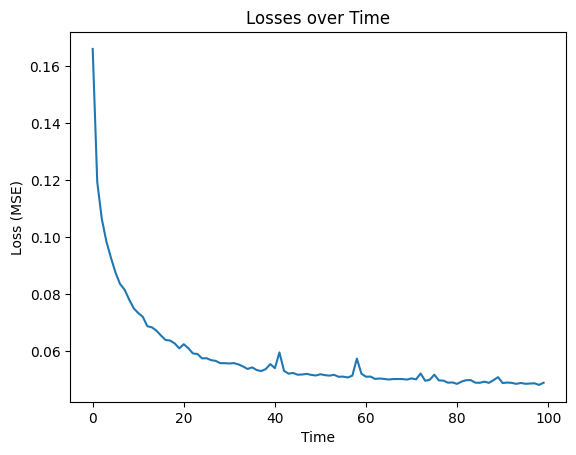

In [21]:
plt.plot(losses)
plt.title("Losses over Time")
plt.xlabel("Time")
plt.ylabel("Loss (MSE)")
plt.show()

Continue to evaluate the model performance by calculating the accuracy score. With a score of approximately .96, we see that the model performed very well.

In [22]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for data, targets in test_loader:
        logits = model(data).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(targets.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9681


A more in-depth report suggests that while the model did extremely well in predicting real job postings, the class imbalance led to a lower recall score for fake job postings, meaning the model caught approximately 50% of all fake job postings.

In [23]:
print(classification_report(all_labels, all_preds, target_names=['Real', 'Fake']))

              precision    recall  f1-score   support

        Real       0.98      0.99      0.98      3395
        Fake       0.76      0.54      0.63       181

    accuracy                           0.97      3576
   macro avg       0.87      0.77      0.81      3576
weighted avg       0.96      0.97      0.97      3576



The confusion matrix further suggests that while real job postings are predicted well, the model struggles to predict fake job postings, assuming that many of them are real. For the purposes of our analysis, this is a large risk, as we do not want job applicants to fall for fake job postings. It's better to assume a job posting is fake when it's real rather than to assume a fake is real and expose your personal information. This is even more serious for students, who could leak transcripts and other sensitive information.

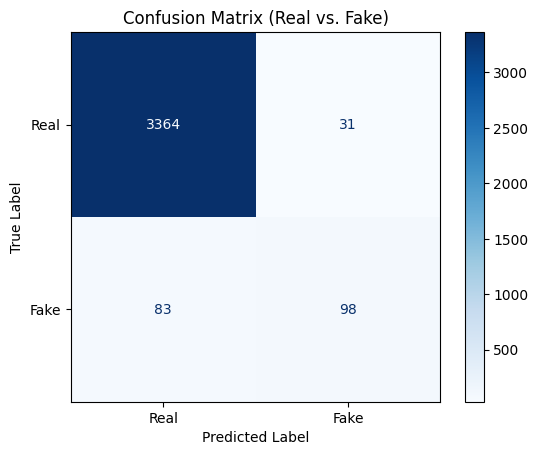

In [24]:
ConfusionMatrixDisplay.from_predictions(
    all_labels,
    all_preds,
    display_labels=['Real', 'Fake'],
    cmap='Blues'
)
plt.title("Confusion Matrix (Real vs. Fake)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## **Insights & Conclusions**

While our models achieved high overall accuracy (i.e. up to 97% with Random Forest), they struggled significantly with identifying fake postings (i.e. recall of 0.52 for the "Fake" class with KNN and Random Forest).

The confusion matrix presents the prediction summary in matrix form. Specifically, 83 fake postings were misclassified as real (false negatives), compared to only 31 real postings misclassified as fake (false positives).

For job seekers who may be submitting sensitive documents and information, false negatives are far riskier than false positives. A missed fake posting could lead to identity theft, while a false alarm on a real posting only costs time.

Currently, models prioritize precision (minimizing false positives) at the expense of recall (missing actual scams). This aligns poorly with user safety needs.

Our preliminary analysis suggests structural features (i.e. missing company logos, vague benefits descriptions) were more reliable fraud indicators than text alone.

Fake postings often exhibited mismatches (i.e. entry-level jobs requesting 10+ years of experience).

## **Going Forward**

As mentioned above, our model prioritizes precision at the expense of recall. However, an ideal detection system should prioritize recall over precision because it's better to flag a legitimate posting as fraudelent than missing actual scams and compromising user data and privacy. There are many other features that can be taken into account, including (NOT FINISHED)